# Notes

Used data from:
- Paper "Protein embeddings and deep learning predict binding residues for various ligand classes" by Littmann et al. available at: https://github.com/Rostlab/bindPredict

**Data explanation**:
- Development set
    - DevSet1014: 1014 proteins (13.999 binding residues + 156.684 non-binding residues)
        - Metal ions: 455 proteins (2.374 binding residues + 77.404 non-binding residues)
        - Nucleic acids: 108 proteins (2.689 binding residues + 15.582 non-binding residues)
        - Small molecules: 606 proteins (9.281 binding residues + 94.119 non-binding residues)
    - TestSet300: 300 proteins (5.869 binding residues + 56.820 non-binding residues)
        - Metal ions: 122 proteins (881 binding residues + 26.763 non-binding residues)
        - Nucleic acids: 66 proteins (1.470 binding residues + 14.698 non-binding residues)
        - Small molecules: 220 proteins (3.906 binding residues + 42.629 non-binding residues)
- Independent set
    - TestSetNew46: 46 proteins (575 binding residues + 6.652 non-binding residues)
        - Metal ions: 15 proteins (77 binding residues + 2.198 non-binding residues)
        - Nucleic acids: 10 proteins (77 binding residues + 874 non-binding residues)
        - Small molecules: 25 proteins (425 binding residues + 3.259 non-binding residues)

**Proposed splits**:
- Working at protein-level (train on sequences with X ligan type(s), test on else (~18% of the proteins have >1 type of ligand)):
    - `one_vs_many`: train on proteins with only 1 type of ligand, test on proteins with 2 and 3 types of ligands
    - `two_vs_many`: train on proteins with 1 or 2 types of ligand, test on proteins with 3 types of ligand
    - `three_vs_many`: train on proteins with 1, 2 or 3 types of ligand from original training set, test on original test sets TestSet300 and TestSetNew46 mixed.

- Working at residue-level (train on sequences with residues assigned to only 1 type of ligand, test on sequences with residues assigned to multiple classes (~4% of the residues have more than one type of ligand)):
    - `one_vs_sm`: train on proteins with residues having only one type of ligand, test on proteins with residues having Small+Metal ligands
    - `one_vs_mn`: train as `one_vs_sm` but with balances classes, test on proteins with residues having Metal+Nuclear
    - `one_vs_sn`: train as `one_vs_sm` but with balances classes, test on proteins with residues having Small+Nuclear

The splits `one_vs_many`, `two_vs_many` and `three_vs_many` aim to analyze the impact of training/testing taking into account that proteins have more than one type of ligands, i.e., we can have proteins with only residues with metal ligands and/or proteins with residues with metal ligand and other residues with small ligand.

On the other hand, the splits `one_vs_sm`, `one_vs_mn` and `one_vs_sn` aim to analyze the impact of training in proteins with residues having only one type of residue and testing on proteins that hve multi-ligand residues.

# Configs & Imports

In [1]:
from pathlib import Path

from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from numpy import NaN

from Bio import SeqIO

from helpers import plot_data_statistics

from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
# Where the raw data is stored and where processed data will be deposited
data_path = Path('') / '..' / 'data' / 'bind'
split_path = Path('') / '..' / 'splits' / 'bind'

# Development set (DevSet1014 & estSet300)
sequences_path = data_path / 'development_set' / 'all.fasta'
binding_residues_metal_path = data_path / 'development_set' / 'binding_residues_2.5_metal.txt'
binding_residues_nuclear_path = data_path / 'development_set' / 'binding_residues_2.5_nuclear.txt'
binding_residues_small_path = data_path / 'development_set' / 'binding_residues_2.5_small.txt'
test_set_path = data_path / 'development_set' / 'uniprot_test.txt'

# Independent (test) set (TestSetNew46)
independent_sequences_path = data_path / 'independent_set' / 'indep_set.fasta'
independent_binding_residues_metal_path = data_path / 'independent_set' / 'binding_residues_metal.txt'
independent_binding_residues_nuclear_path = data_path / 'independent_set' / 'binding_residues_nuclear.txt'
independent_binding_residues_small_path = data_path / 'independent_set' / 'binding_residues_small.txt'
independent_set_path = data_path / 'independent_set' / 'indep_set.txt'

# Obtain original datasets

In [3]:
# Function to encapsulate reading from fasta files
def getProteinsFromFASTAFile(filePath):
    columns = ["id", "sequence"]
    dataset = DataFrame(columns = columns)
    
    for protein in SeqIO.parse(filePath, "fasta"):
        dataset = dataset.append({"id": protein.id,
                                  "sequence": str(protein.seq)}, ignore_index=True)
    
    return dataset

In [4]:
# Obtain data from sets
sequences = getProteinsFromFASTAFile(sequences_path)
binding_residues_metal = read_csv(binding_residues_metal_path, sep="	", names=["id", "binding residues"])
binding_residues_nuclear = read_csv(binding_residues_nuclear_path, sep="	", names=["id", "binding residues"])
binding_residues_small = read_csv(binding_residues_small_path, sep="	", names=["id", "binding residues"])
test_set = read_csv(test_set_path, names=["id"])

independent_sequences = getProteinsFromFASTAFile(independent_sequences_path)
independent_binding_residues_metal = read_csv(independent_binding_residues_metal_path, sep="	", names=["id", "binding residues"])
independent_binding_residues_nuclear = read_csv(independent_binding_residues_nuclear_path, sep="	", names=["id", "binding residues"])
independent_binding_residues_small = read_csv(independent_binding_residues_small_path, sep="	", names=["id", "binding residues"])
independent_set = read_csv(independent_set_path, names=["id"])

# Construct base datasets

In [5]:
# Let's construct a single development dataset with all the information together
sequences_with_binding_info = DataFrame(columns = ["id", "sequence", "metal", "nuclear", "small", "set"])

for index, row in sequences.iterrows():
    # Determine the binding type and the binding residues
    metal, nuclear, small = NaN, NaN, NaN
    if row["id"] in list(binding_residues_metal["id"]):
        metal = binding_residues_metal.iloc[list(binding_residues_metal["id"]).index(row["id"])]["binding residues"]
    
    if row["id"] in list(binding_residues_nuclear["id"]):
        nuclear = binding_residues_nuclear.iloc[list(binding_residues_nuclear["id"]).index(row["id"])]["binding residues"]
    
    if row["id"] in list(binding_residues_small["id"]):
        small = binding_residues_small.iloc[list(binding_residues_small["id"]).index(row["id"])]["binding residues"]
    
    # Train/validation or test
    train_or_test = "train"
    if row["id"] in list(test_set["id"]):
        train_or_test = "test"
    
    new_sequence = {"id": row["id"], 
                    "sequence": row["sequence"], 
                    "metal": metal,
                    "nuclear": nuclear,
                    "small": small,
                    "set": train_or_test}
    sequences_with_binding_info = sequences_with_binding_info.append(new_sequence, ignore_index = True)

In [6]:
# Let's construct a single independent dataset with all the information together
independent_sequences_with_binding_info = DataFrame(columns = ["id", "sequence", "metal", "nuclear", "small", "set"])

for index, row in independent_sequences.iterrows():
    # Determine the binding type and the binding residues
    metal, nuclear, small = NaN, NaN, NaN
    if row["id"] in list(independent_binding_residues_metal["id"]):
        metal = independent_binding_residues_metal.iloc[list(independent_binding_residues_metal["id"]).index(row["id"])]["binding residues"]
    
    if row["id"] in list(independent_binding_residues_nuclear["id"]):
        nuclear = independent_binding_residues_nuclear.iloc[list(independent_binding_residues_nuclear["id"]).index(row["id"])]["binding residues"]
    
    if row["id"] in list(independent_binding_residues_small["id"]):
        small = independent_binding_residues_small.iloc[list(independent_binding_residues_small["id"]).index(row["id"])]["binding residues"]
    
    # Train/validation or test
    train_or_test = "train"
    if row["id"] in list(test_set["id"]):
        train_or_test = "test"
    
    new_sequence = {"id": row["id"], 
                    "sequence": row["sequence"], 
                    "metal": metal,
                    "nuclear": nuclear,
                    "small": small,
                    "set": train_or_test}
    independent_sequences_with_binding_info = independent_sequences_with_binding_info.append(new_sequence, ignore_index = True)

In [7]:
# Let's mix both test set to acquire a bigger test set since the unique difference is the acquisition moment
full_set = sequences_with_binding_info.append(independent_sequences_with_binding_info)
full_set

,id,sequence,metal,nuclear,small,set
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,NaN,NaN,"53,46,32,42,25,60,56,43,57,31,54,22,34,40,26,2...",train
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,"51,62,42,60,55,64",NaN,NaN,train
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,NaN,NaN,"100,46,104,88,63,42,77,135,91,108,27,101,134,1...",train
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,NaN,NaN,"37,36,40,61",train
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,"83,77",NaN,"30,117,118,116",train
...,...,...,...,...,...,...
41,Q9KDJ7,MSDEKKILGEERRSLLIKWLKASDTPLTGAELAKRTNVSRQVIVQD...,"150,152,91",NaN,"130,134,105,141,142,83,150,88,91,92,152",train
42,Q9LFM3,MGAGREVSVSLDGVRDKNLMQLKILNTVLFPVRYNDKYYADAIAAG...,NaN,NaN,"129,79,80,81,82,83,88,89,90,91,92,93,94,114,11...",train
43,Q9SJ89,MNLQAVSCSFGFLSSPLGVTPRTSFRRFVIRAKTEPSEKSVEIMRK...,NaN,NaN,"69,85,86,104,106,109,115,116,117,119,120",train
44,U2EQ00,MAWLILIIAGIFEVVWAIALKYSNGFTRLIPSMITLIGMLISFYLL...,NaN,NaN,"64,65,68,13,16,25,26,27,29,33,98,36,39,40,43,4...",train


In [8]:
# Let's encode the proteins in binary-fashion 
# in order to represent the type of ligands over the amino acids of the sequences
# Encoding: SNM (Small Nuclear Metal), i.e., 000 = No binding, 001 = Metal, 010 = Nuclear, 100 = Small
# Combinations such as 101 (Small + Metal) allows for representing residues with more than 1 type of ligand
full_set_encoded = DataFrame(columns = ["id", "sequence", "encoding", "set"])
for i in range(len(full_set)):
    encoded_seq = [0b000]*len(full_set.iloc[i].sequence)
    
    if full_set.iloc[i].metal is not NaN:
        metal = list(map(int, full_set.iloc[i].metal.split(",")))
        for residue in metal:
            encoded_seq[residue - 1] = encoded_seq[residue - 1] | 0b001
            
    if full_set.iloc[i].nuclear is not NaN:
        nuclear = list(map(int, full_set.iloc[i].nuclear.split(",")))
        for residue in nuclear:
            encoded_seq[residue - 1] = encoded_seq[residue - 1] | 0b010
    
    if full_set.iloc[i].small is not NaN:
        small = list(map(int, full_set.iloc[i].small.split(",")))
        for residue in small:
            encoded_seq[residue - 1] = encoded_seq[residue - 1] | 0b100
    
    full_set_encoded = full_set_encoded.append({"id": full_set.iloc[i].id,
                                                "sequence": full_set.iloc[i].sequence, 
                                                "encoding": encoded_seq,
                                                "set": full_set.iloc[i].set }, ignore_index=True)

In [9]:
full_set_encoded

,id,sequence,encoding,set
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
...,...,...,...,...
1355,Q9KDJ7,MSDEKKILGEERRSLLIKWLKASDTPLTGAELAKRTNVSRQVIVQD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
1356,Q9LFM3,MGAGREVSVSLDGVRDKNLMQLKILNTVLFPVRYNDKYYADAIAAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
1357,Q9SJ89,MNLQAVSCSFGFLSSPLGVTPRTSFRRFVIRAKTEPSEKSVEIMRK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train
1358,U2EQ00,MAWLILIIAGIFEVVWAIALKYSNGFTRLIPSMITLIGMLISFYLL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ...",train


# Subsets & Statistics

## Protein-level

In [10]:
# Get index in dataframes for proteins with only 1, with 2 and with 3 type of ligand
one_ligand_indexes = [index for index, row in full_set.iterrows() if row.isna().sum() == 2]
two_ligand_indexes = [index for index, row in full_set.iterrows() if row.isna().sum() == 1]
three_ligand_indexes = [index for index, row in full_set.iterrows() if row.isna().sum() == 0]

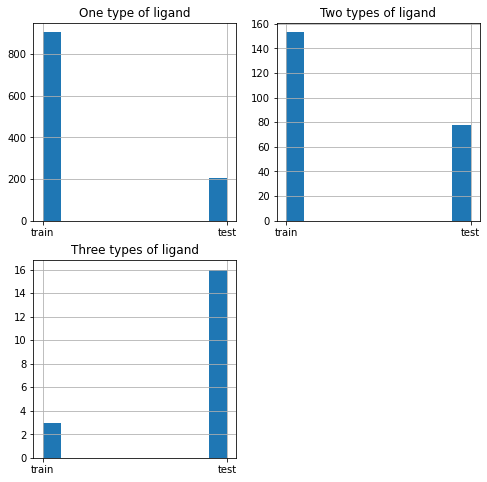

In [11]:
# Let's visualize the distribution and counts of number of ligands per sequence in the original training & test sets
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
full_set.iloc[one_ligand_indexes]["set"].hist(ax=ax[0,0])
ax[0,0].set_title("One type of ligand")
full_set.iloc[two_ligand_indexes]["set"].hist(ax=ax[0,1])
ax[0,1].set_title("Two types of ligand")
full_set.iloc[three_ligand_indexes]["set"].hist(ax=ax[1,0])
ax[1,0].set_title("Three types of ligand")
ax[1,1].set_visible(False)

In [12]:
# Get index in dataframes for proteins with small, with nuclear and with metal
small_indexes = [index for index, row in full_set.iterrows() if row.small is not NaN]
nuclear_indexes = [index for index, row in full_set.iterrows() if row.nuclear is not NaN]
metal_indexes = [index for index, row in full_set.iterrows() if row.metal is not NaN]

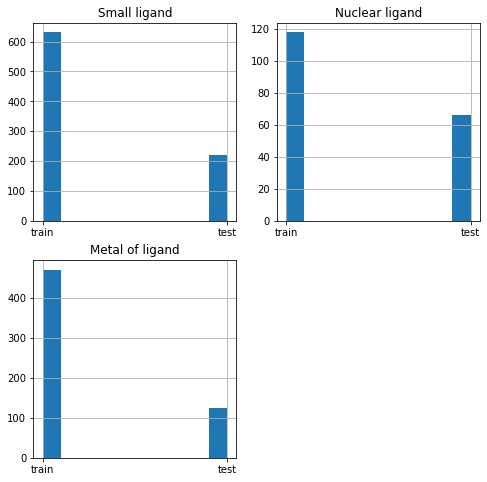

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
full_set.iloc[small_indexes]["set"].hist(ax=ax[0,0])
ax[0,0].set_title("Small ligand")
full_set.iloc[nuclear_indexes]["set"].hist(ax=ax[0,1])
ax[0,1].set_title("Nuclear ligand")
full_set.iloc[metal_indexes]["set"].hist(ax=ax[1,0])
ax[1,0].set_title("Metal of ligand")
ax[1,1].set_visible(False)

In [14]:
# Get index in dataframes for proteins with ONLY small, with ONLY nuclear and with ONLY metal
small_indexes_set = set(small_indexes)
nuclear_indexes_set = set(nuclear_indexes)
metal_indexes_set = set(metal_indexes)

only_small_indexes = list(small_indexes_set - nuclear_indexes_set.union(metal_indexes_set))
only_nuclear_indexes = list(nuclear_indexes_set - small_indexes_set.union(metal_indexes_set))
only_metal_indexes = list(metal_indexes_set - nuclear_indexes_set.union(small_indexes_set))

#del small_indexes_set, nuclear_indexes_set, metal_indexes_set

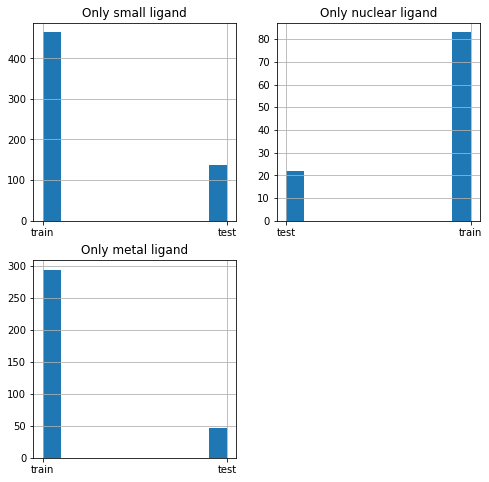

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
full_set.iloc[only_small_indexes]["set"].hist(ax=ax[0,0])
ax[0,0].set_title("Only small ligand")
full_set.iloc[only_nuclear_indexes]["set"].hist(ax=ax[0,1])
ax[0,1].set_title("Only nuclear ligand")
full_set.iloc[only_metal_indexes]["set"].hist(ax=ax[1,0])
ax[1,0].set_title("Only metal ligand")
ax[1,1].set_visible(False)

## Residue-level

In [16]:
# Get index in dataframes for proteins with residues having only small, metal or nuclear ligands
only_metal_residues_indexes = []
only_nuclear_residues_indexes = []
only_small_residues_indexes = []

metal_and_nuclear_residues_indexes = []
small_and_metal_residues_indexes = []
small_and_nuclear_residues_indexes = []
metal_small_and_nuclear_residues_indexes = []

for i in range(len(full_set_encoded)):
    encoded_seq = full_set_encoded.iloc[i]["encoding"]
    if all(res == 0 or res == 1 for res in encoded_seq): # No binding (0) & Metal (1)
        only_metal_residues_indexes.append(i)
    
    elif all(res == 0 or res == 2 for res in encoded_seq): # No binding (0) & Nuclear (2)
        only_nuclear_residues_indexes.append(i)
    
    elif all(res == 0 or res == 4 for res in encoded_seq): # No binding (0) & Small (4)
        only_small_residues_indexes.append(i)
        
    if any(res == 3 for res in encoded_seq): # No binding (0) & Metal+Nuclear (3)
        metal_and_nuclear_residues_indexes.append(i)
    
    if any(res == 5 for res in encoded_seq): # No binding (0) & Small+Metal (5)
        small_and_metal_residues_indexes.append(i)
        
    if any(res == 6 for res in encoded_seq): # No binding (0) & Small+Nuclear (6)
        small_and_nuclear_residues_indexes.append(i)
        
    if any(res == 7 for res in encoded_seq): # No binding (0) & Small+Nuclear+Metal (7)
        metal_small_and_nuclear_residues_indexes.append(i)

In [17]:
display("only_metal_residues_indexes" + ": " + str(len(only_metal_residues_indexes)))
display("only_nuclear_residues_indexes" + ": " + str(len(only_nuclear_residues_indexes)))
display("only_small_residues_indexes" + ": " + str(len(only_small_residues_indexes)))

display("metal_and_nuclear_residues_indexes" + ": " + str(len(metal_and_nuclear_residues_indexes)))
display("small_and_metal_residues_indexes" + ": " + str(len(small_and_metal_residues_indexes)))
display("small_and_nuclear_residues_indexes" + ": " + str(len(small_and_nuclear_residues_indexes)))
display("metal_small_and_nuclear_residues_indexes" + ": " + str(len(metal_small_and_nuclear_residues_indexes)))

'only_metal_residues_indexes: 364'

'only_nuclear_residues_indexes: 115'

'only_small_residues_indexes: 631'

'metal_and_nuclear_residues_indexes: 32'

'small_and_metal_residues_indexes: 134'

'small_and_nuclear_residues_indexes: 21'

'metal_small_and_nuclear_residues_indexes: 7'

In [18]:
# As we are considering proteins with residues with ONLY ONE type of ligand 
# and proteins with residues with more than one type of ligand, we are losing proteins
# For example the protein 4, which has residues with metal ligands and residues with small residues
indexes = set(only_metal_residues_indexes).union(set(only_nuclear_residues_indexes)) \
    .union(set(only_small_residues_indexes)) \
   .union(set(metal_and_nuclear_residues_indexes)) \
   .union(set(small_and_metal_residues_indexes)) \
   .union(set(small_and_nuclear_residues_indexes)) \
   .union(set(metal_small_and_nuclear_residues_indexes))

notIncluded = []
for i in range(len(full_set)):
    if i not in indexes:
        notIncluded.append(i)

len(notIncluded)

73

In [19]:
# We lose 73/1360 proteins
str(notIncluded)

'[4, 35, 53, 70, 105, 108, 113, 145, 150, 161, 166, 205, 216, 246, 282, 370, 385, 397, 415, 465, 482, 500, 539, 552, 575, 654, 681, 682, 733, 748, 775, 778, 785, 796, 801, 812, 860, 872, 889, 892, 897, 901, 902, 934, 969, 1037, 1053, 1066, 1103, 1127, 1133, 1140, 1141, 1145, 1154, 1159, 1162, 1170, 1199, 1200, 1234, 1242, 1244, 1248, 1257, 1270, 1277, 1279, 1285, 1302, 1311, 1329, 1345]'

# Splits working at protein-level

## one_vs_many

In [21]:
one_vs_many = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Training set
tmp = full_set_encoded.iloc[one_ligand_indexes][["sequence", "encoding"]]
tmp.rename(columns = {"encoding": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(full_set_encoded.iloc[one_ligand_indexes]))
one_vs_many = one_vs_many.append(tmp)

# Validation set 
val_sample_indexs = list(one_vs_many.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in one_vs_many.index]
one_vs_many.validation = validation

# Test set
tmp = full_set_encoded.iloc[two_ligand_indexes].append(full_set_encoded.iloc[three_ligand_indexes])[["sequence", "encoding"]]
tmp.rename(columns = {"encoding": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
one_vs_many = one_vs_many.append(tmp)

# Target to str
one_vs_many["target"] = one_vs_many["target"].apply(lambda x: ''.join(map(str, x)))

one_vs_many = one_vs_many.reset_index()
one_vs_many.drop(["index"], axis=1, inplace=True)

In [22]:
one_vs_many.to_csv(split_path / 'splits' / 'one_vs_many.csv', index = False)

## two_vs_many

In [23]:
two_vs_many = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Training set
tmp = full_set_encoded.iloc[one_ligand_indexes][["sequence", "encoding"]]
tmp.rename(columns = {"encoding": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(full_set_encoded.iloc[one_ligand_indexes]))
one_vs_many = two_vs_many.append(tmp)

tmp = full_set_encoded.iloc[two_ligand_indexes][["sequence", "encoding"]]
tmp.rename(columns = {"encoding": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(full_set_encoded.iloc[two_ligand_indexes]))
one_vs_many = two_vs_many.append(tmp)

# Validation set 
val_sample_indexs = list(two_vs_many.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in two_vs_many.index]
two_vs_many.validation = validation

# Test set
tmp = full_set_encoded.iloc[three_ligand_indexes][["sequence", "encoding"]]
tmp.rename(columns = {"encoding": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
two_vs_many = two_vs_many.append(tmp)

# Target to str
two_vs_many["target"] = two_vs_many["target"].apply(lambda x: ''.join(map(str, x)))

two_vs_many = two_vs_many.reset_index()
two_vs_many.drop(["index"], axis=1, inplace=True)

In [24]:
two_vs_many.to_csv(split_path / 'splits' / 'two_vs_many.csv', index = False)

## three_vs_many

In [25]:
three_vs_many = full_set_encoded[["sequence", "encoding", "set"]]

three_vs_many.rename(columns = {"encoding": "target"}, inplace = True)

# Let's specify validation set
val_sample_indexs = list(three_vs_many.query("set == 'train'").sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in three_vs_many.index]
three_vs_many.insert(2, "validation", validation)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [26]:
three_vs_many.to_csv(split_path / 'splits' / 'three_vs_many.csv', index = False)

# Splits working at residue-level

We train with
- Proteins with only residues with metal ligand: 364
- Proteins with only residues with nuclear ligand: 115
- Proteins with only residues with small ligand: 631

Options for multiclass testing:
- M+N: 32 <- Reduce the training set to (M) 364/3, (N) 115/3 and (S) 631/5 => 32/(364/3+115/3+631/5) $\approx$ 11% (test)
- S+M: 134 <-- Used as it is because 134/(364+115+631) $\approx$ 12% (test)
- S+N: 21 <-- Reduce the training set to (M) 364/6, (N) 115/4, (S) 631/6 => 21/(364/6+115/4+631/6) $\approx$ 11% (test)
- S+M+N: 7 <-- Discarded because it only has 7 proteins.

In [27]:
# We have the same training for all the splits from here
# Training
trainingIndexes = only_metal_residues_indexes + only_nuclear_residues_indexes + only_small_residues_indexes
training = full_set_encoded.iloc[trainingIndexes][["sequence", "encoding"]]
training.rename(columns = {"encoding": "target"}, inplace = True)
training.insert(2, "set", ["train"]*len(trainingIndexes))

## one_vs_sm

In [28]:
one_vs_sm = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Training
one_vs_sm = one_vs_sm.append(training)

# Validation
val_sample_indexs = list(training.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in training.index]
one_vs_sm.validation = validation

# Test
sm = full_set_encoded.iloc[small_and_metal_residues_indexes][["sequence", "encoding"]]
sm.rename(columns = {"encoding": "target"}, inplace = True)
sm.insert(2, "set", ["test"]*len(small_and_metal_residues_indexes))
one_vs_sm = one_vs_sm.append(sm)

# Target to str
one_vs_sm["target"] = one_vs_sm["target"].apply(lambda x: ''.join(map(str, x)))

In [29]:
one_vs_sm.to_csv(split_path / 'splits' / 'one_vs_sm.csv', index = False)

## one_vs_mn

In [30]:
one_vs_mn = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Training
subsample_m = full_set_encoded.iloc[only_metal_residues_indexes].sample(n=int(len(only_metal_residues_indexes)/3), random_state=1234)
subsample_n = full_set_encoded.iloc[only_nuclear_residues_indexes].sample(n=int(len(only_nuclear_residues_indexes)/3), random_state=1234)
subsample_s = full_set_encoded.iloc[only_small_residues_indexes].sample(n=int(len(only_small_residues_indexes)/5), random_state=1234)
training = subsample_m.append(subsample_n).append(subsample_s)[["sequence", "encoding"]]
training.rename(columns = {"encoding": "target"}, inplace = True)
training.insert(2, "set", ["train"]*len(training))
one_vs_mn = one_vs_mn.append(training)

# Validation
val_sample_indexs = list(training.sample(n=int(0.10*(len(training)+len(metal_and_nuclear_residues_indexes))), random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in training.index]
one_vs_mn.validation = validation


# Test
mn = full_set_encoded.iloc[metal_and_nuclear_residues_indexes][["sequence", "encoding"]]
mn.rename(columns = {"encoding": "target"}, inplace = True)
mn.insert(2, "set", ["test"]*len(metal_and_nuclear_residues_indexes))
one_vs_mn = one_vs_mn.append(mn)

# Target to str
one_vs_mn["target"] = one_vs_mn["target"].apply(lambda x: ''.join(map(str, x)))

In [31]:
one_vs_mn.to_csv(split_path / 'splits' / 'one_vs_mn.csv', index = False)

## one_vs_sn

In [32]:
one_vs_sn = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Training
subsample_m = full_set_encoded.iloc[only_metal_residues_indexes].sample(n=int(len(only_metal_residues_indexes)/6), random_state=1234)
subsample_n = full_set_encoded.iloc[only_nuclear_residues_indexes].sample(n=int(len(only_nuclear_residues_indexes)/4), random_state=1234)
subsample_s = full_set_encoded.iloc[only_small_residues_indexes].sample(n=int(len(only_small_residues_indexes)/6), random_state=1234)
training = subsample_m.append(subsample_n).append(subsample_s)[["sequence", "encoding"]]
training.rename(columns = {"encoding": "target"}, inplace = True)
training.insert(2, "set", ["train"]*len(training))
one_vs_sn = one_vs_sn.append(training)

# Validation
val_sample_indexs = list(training.sample(n=int(0.10*(len(training)+len(small_and_nuclear_residues_indexes))), random_state=1234).index)
validation = [True if i in val_sample_indexs else NaN for i in training.index]
one_vs_sn.validation = validation

# Test
sn = full_set_encoded.iloc[small_and_nuclear_residues_indexes][["sequence", "encoding"]]
sn.rename(columns = {"encoding": "target"}, inplace = True)
sn.insert(2, "set", ["test"]*len(small_and_nuclear_residues_indexes))
one_vs_sn = one_vs_mn.append(sn)

# Target to str
one_vs_sn["target"] = one_vs_sn["target"].apply(lambda x: ''.join(map(str, x)))

In [33]:
one_vs_sn.to_csv(split_path / 'splits' / 'one_vs_sn.csv', index = False)